In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io
import math

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

In [2]:
from utils import *
from data import *
from models import *
from train import *

In [3]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [5]:
data_mit = import_mit_data()

In [6]:
beats = []
freq = 360

for i,patient in tqdm(enumerate(data_mit), total=len(data_mit)):
    for waveform, label in patient:
        rpeaks = wfdb.processing.xqrs_detect(waveform, fs=freq, verbose=False)

        for peak in rpeaks:
            if peak >= freq/2 and peak < len(waveform) - freq/2:
                partial_wave = waveform[peak-freq//2:peak+freq//2]
                partial_wave,_ = pywt.dwt(partial_wave, 'db6')
                partial_wave,_ = pywt.dwt(partial_wave, 'db6')
                beats.append((partial_wave, label, i)) 

100%|██████████| 48/48 [01:11<00:00,  1.49s/it]


In [7]:
beats[1000]

(array([-0.48653093, -0.52550738, -0.54090974, -0.49977151, -0.49303832,
        -0.49508027, -0.54647274, -0.52083588, -0.48870489, -0.49649643,
        -0.50309328, -0.48417202, -0.49393639, -0.48350579, -0.50730182,
        -0.53478639, -0.53133982, -0.52555819, -0.52737808, -0.52930386,
        -0.53796072, -0.55645202, -0.56148229, -0.58584673, -0.56586105,
        -0.55258514, -0.55736089, -0.53886046, -0.53682786, -0.56014755,
        -0.5556316 , -0.51642019, -0.43759544, -0.38100736, -0.34384513,
        -0.32122671, -0.35634075, -0.35353737, -0.35004944, -0.2714135 ,
        -0.3643947 , -0.48657   , -0.57553652, -0.57446683, -0.59970587,
        -0.58421751, -0.58892769, -0.59025968, -0.75057348, -1.00088145,
        -0.47500557,  1.68062488,  1.76246428, -0.49532649, -0.66768876,
        -0.66264251, -0.69803416, -0.68821537, -0.69175046, -0.70746479,
        -0.70775166, -0.70824397, -0.73308082, -0.72430196, -0.70585589,
        -0.72938336, -0.72802546, -0.72281864, -0.7

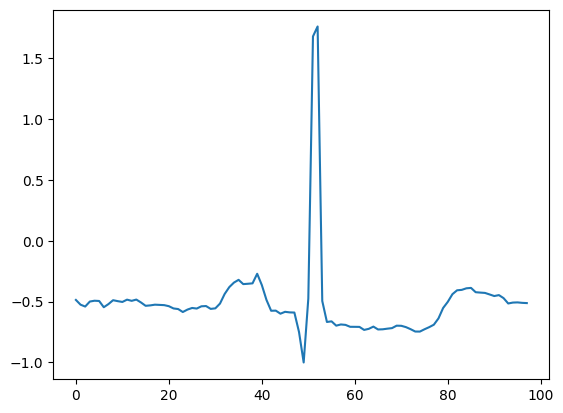

In [8]:
def plotbeat(x):
    if type(x) is tuple:
        plt.plot(x[0])
    else:
        plt.plot(x)

plotbeat(beats[1000])

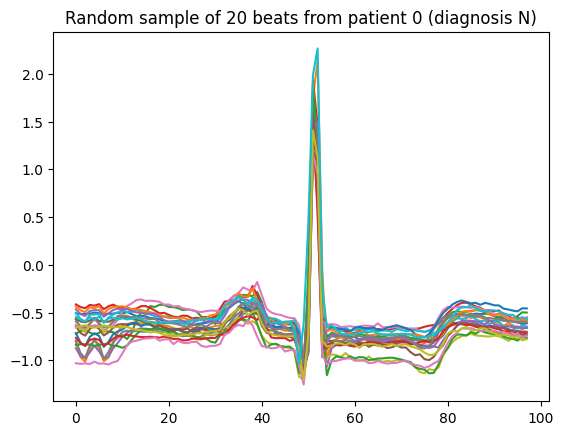

In [9]:
def plot_patient_beat_sample(patient, k):

    patient_beats = [x for x in beats if x[2] == patient]
    patient_beats = random.sample(patient_beats, k)

    for beat in patient_beats:
        plotbeat(beat)

    plt.title(f'Random sample of {k} beats from patient {patient} (diagnosis {beat[1]})')

plot_patient_beat_sample(0, 20)  

# Dataset

In [10]:
labels = list(set([x[1] for x in beats]))
label_map = {label:i for i,label in enumerate(labels)}

In [11]:
class BeatDataset(Dataset):
    def __init__(self, data, device, label_map, specify_patient=None):
        self.data = []

        for waveform, label, patient in tqdm(data):
            if specify_patient:
                if patient != specify_patient:
                    continue
                

            ## Z-score Normalisation
            waveform = (waveform - waveform.mean()) / waveform.std()

            self.data.append((
                torch.tensor(waveform, device=device, dtype=torch.float32),
                torch.tensor(label_map[label], device=device),
                patient
            ))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        waveform, label, patient = self.data[idx]

        return waveform, label
    
# beat_dataset = BeatDataset(random.sample(beats, 10), device, label_map)
beat_dataset = BeatDataset(beats, device, label_map)
beat_dataloader = DataLoader(beat_dataset, batch_size=128, shuffle=True)

100%|██████████| 76851/76851 [00:05<00:00, 14067.96it/s]


In [12]:
class Encoder(nn.Module):
    def __init__(self, lstm_count=32):
        super().__init__()

        self.lstm1 = nn.LSTM(input_size=1, hidden_size=lstm_count, batch_first=True)
        self.dropout = nn.Dropout(0.05)
        self.lstm2 = nn.LSTM(input_size=lstm_count, hidden_size=lstm_count, batch_first=True)

        self.fc_encoding_1 = nn.Linear(lstm_count*2, lstm_count*2)
        self.fc_encoding_2 = nn.Linear(lstm_count*2, lstm_count*2)
        self.fc_encoding_3 = nn.Linear(lstm_count*2, lstm_count)

    def forward(self, x):
        x = x.reshape((x.shape[0], x.shape[1], 1))
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        _, hidden = self.lstm2(x)

        x = torch.cat(hidden, axis=2)
        x = x.squeeze(0)

        x = self.fc_encoding_1(x)
        x = F.sigmoid(x)
        x = self.fc_encoding_2(x)
        x = F.sigmoid(x)
        x = self.fc_encoding_3(x)
        x = F.sigmoid(x)

        return x
    
class Decoder(nn.Module):
    def __init__(self, seq_len=98, lstm_count=32):
        super().__init__()

        self.seq_len = seq_len
        self.lstm_count = lstm_count
        
        self.lstm1 = nn.LSTM(input_size=lstm_count, hidden_size=lstm_count, batch_first=True)
        self.dropout = nn.Dropout(0.05)
        self.lstm2 = nn.LSTM(input_size=lstm_count, hidden_size=lstm_count, batch_first=True)
        self.output_layer = nn.Linear(lstm_count, 1)

        self.fc_decoding_1 = nn.Linear(lstm_count, lstm_count*2)
        self.fc_decoding_2 = nn.Linear(lstm_count*2, lstm_count*2)
        self.fc_decoding_3 = nn.Linear(lstm_count*2, lstm_count*2)

    def forward(self, x):
        x = self.fc_decoding_1(x)
        x = F.sigmoid(x)
        x = self.fc_decoding_2(x)
        x = F.sigmoid(x)
        x = self.fc_decoding_3(x)

        x = x.unsqueeze(0)

        x = [x[:,:,:self.lstm_count].contiguous(),x[:,:,self.lstm_count:].contiguous()]

        x,_ = self.lstm1(torch.zeros([x[0].shape[1], self.seq_len, x[0].shape[2]], device=x[0].device), x)
        x = self.dropout(x)
        x,_ = self.lstm2(x)
        x = self.output_layer(x)

        return x.squeeze(2)

class AEModel(nn.Module):
    def __init__(self, lstm_count=32):
        super().__init__()

        self.encoder = Encoder(lstm_count=lstm_count)
        self.decoder = Decoder(lstm_count=lstm_count)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = AEModel(lstm_count=16).to(device)
model_path = 'autoencoder16_squeeze.pt'
model.load_state_dict(torch.load(model_path), strict=False)

<All keys matched successfully>

In [11]:
# Freeze all parameters in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters in encoder.fc_encoding
for param in model.encoder.fc_encoding_1.parameters():
    param.requires_grad = True
for param in model.encoder.fc_encoding_2.parameters():
    param.requires_grad = True
for param in model.encoder.fc_encoding_3.parameters():
    param.requires_grad = True

# Unfreeze the parameters in decoder.fc_decoding
for param in model.decoder.fc_decoding_1.parameters():
    param.requires_grad = True
for param in model.decoder.fc_decoding_2.parameters():
    param.requires_grad = True
for param in model.decoder.fc_decoding_3.parameters():
    param.requires_grad = True

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

losses = []

In [13]:
for epoch in range(10000):
    model.train()

    for i,batch in enumerate(beat_dataloader, 0):

        optimizer.zero_grad()

        seq, label = batch

        seq_pred = model.forward(seq)

        loss = criterion(seq, seq_pred)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.)
        optimizer.step()

    if epoch % 10 == 0:
        model.eval()

        totalloss = 0.

        with torch.no_grad():
            for i,batch in enumerate(beat_dataloader, 0):
                seq, label = batch

                seq_pred = model.forward(seq)

                loss = criterion(seq, seq_pred)

                totalloss += loss.item()

        print(f'epoch {epoch}, loss {totalloss}')
        losses.append(totalloss)

    # if epoch % 100 == 0:
    #     torch.save(model.state_dict(), model_path)

epoch 0, loss 612.5256412029266
epoch 10, loss 428.7996545433998
epoch 20, loss 392.33462208509445
epoch 30, loss 384.7781984806061
epoch 40, loss 371.76485401391983
epoch 50, loss 368.8946999311447
epoch 60, loss 361.6670912504196
epoch 70, loss 355.5879388451576
epoch 80, loss 353.6987375020981
epoch 90, loss 350.5848413705826
epoch 100, loss 348.67614847421646
epoch 110, loss 349.1608060002327
epoch 120, loss 349.0490084886551
epoch 130, loss 343.345990896225
epoch 140, loss 341.7917718887329
epoch 150, loss 342.2820723056793
epoch 160, loss 340.14833587408066
epoch 170, loss 340.45102220773697
epoch 180, loss 338.76812064647675
epoch 190, loss 341.30328983068466
epoch 200, loss 337.2314686179161
epoch 210, loss 336.2719408273697
epoch 220, loss 335.27196073532104
epoch 230, loss 337.4357308745384
epoch 240, loss 334.93301153182983
epoch 250, loss 334.4479285776615
epoch 260, loss 337.3307109475136
epoch 270, loss 333.3647291660309
epoch 280, loss 334.1204244494438
epoch 290, loss 3

KeyboardInterrupt: 

In [44]:
torch.save(model.state_dict(), model_path)

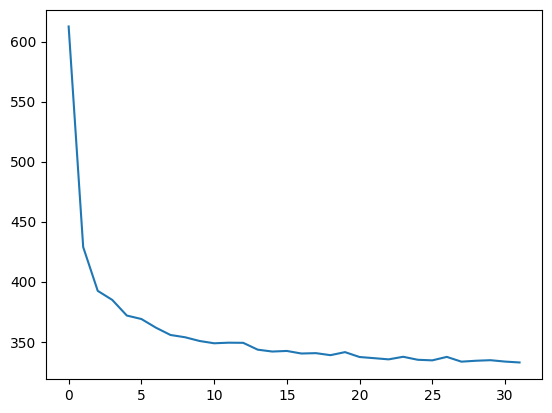

In [15]:
# plt.plot([np.log(x) for x in losses])
plt.plot(losses)

Text(0.5, 1.0, 'Autoencoder replicated heartbeat')

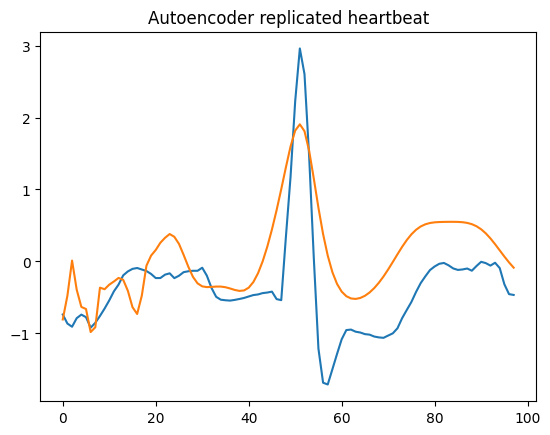

In [13]:
# i = 12425
# i=11422
i = 16624

seq, label, _ = beats[i]
seq = torch.tensor(seq, dtype=torch.float32, device=device)
seq = seq.reshape((1,98))
model.eval()
seq_pred = model.forward(seq)

plt.plot(seq.detach().cpu().numpy().reshape(-1))
plt.plot(seq_pred.detach().cpu().numpy().reshape(-1))

plt.title('Autoencoder replicated heartbeat')


# Distribution Difference

In [14]:
users = [{key:[] for key in label_map.keys()} for i in range(48)]

for beat in beats:
    users[beat[2]][beat[1]].append(beat[0])

In [15]:
def encode(beats):
    values = np.stack(beats, axis=1).reshape((-1, 98))
    seq = torch.tensor(values, dtype=torch.float32, device=device)
    model.eval()
    with torch.no_grad():
        encoded = model.encoder.forward(seq)
    # encoded = torch.concat(encoded, dim=2).squeeze(0)
    return encoded

In [16]:
category = 'N'

groups = []
for patient in users:
    if len(patient[category]) > 1000:
        groups.append(patient[category])

len(groups)

31

## Heuristics

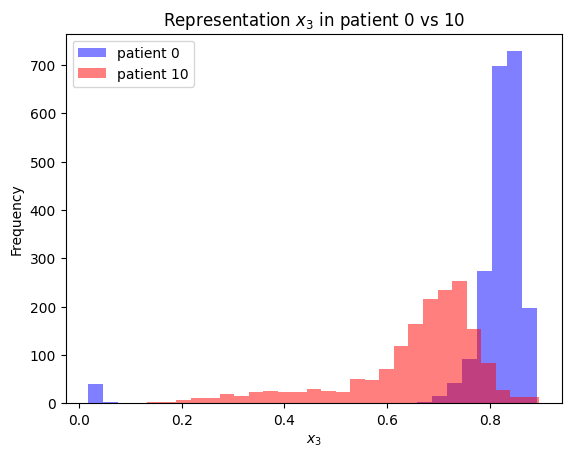

In [51]:
def plot_hist_comparison(groups, a, b, i):
    A = encode(groups[a]).detach().cpu().numpy()
    B = encode(groups[b]).detach().cpu().numpy()

    plt.hist(A[:,i], bins=30, alpha=0.5, label='Dataset 1', color='blue')  # Dataset 1 in blue
    plt.hist(B[:,i], bins=30, alpha=0.5, label='Dataset 2', color='red')   # Dataset 2 in red

    plt.xlabel(f'$x_{{{i}}}$')
    plt.ylabel('Frequency')
    plt.title(f'Representation $x_{i}$ in patient {a} vs {b}')
    plt.legend([f'patient {a}', f'patient {b}'])

    plt.show()

plot_hist_comparison(groups, 0, 10, 3)

0.024450038491349222


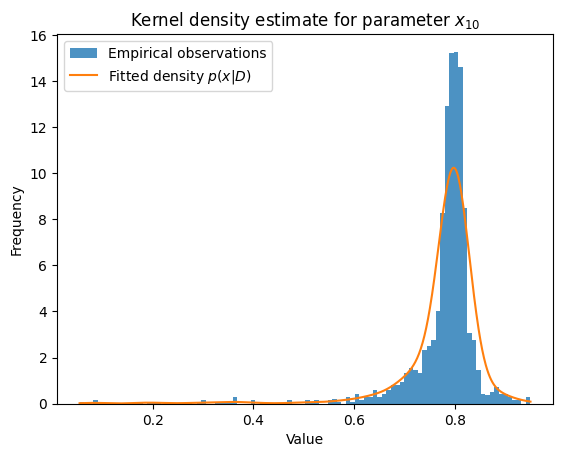

In [25]:
def estimate_bandwidth(data):
    h_d = []

    for i in range(data.shape[1]):
        h_d.append(math.pow(4/(3*data.shape[0]), 0.2) * data[:,i].std())

    return np.prod(h_d) ** (1/len(h_d))

def plot_kde(beats, i, bandwidth):
    x = encode(beats).detach().cpu().numpy()

    x_d = np.linspace(min(x[:,i]), max(x[:,i]), 1000)

    print(estimate_bandwidth(x))
    kde_D1 = KernelDensity(bandwidth=estimate_bandwidth(x), kernel='gaussian')
    kde_D1.fit(x[:,i].reshape(-1, 1))  # Reshape data for fitting
    log_density = kde_D1.score_samples(x_d.reshape(-1, 1))


    plt.hist(x[:,i], bins=100, density=True, alpha=0.8, label='Histogram')
    plt.plot(x_d, np.exp(log_density), label='KDE')

    plt.title(f'Kernel density estimate for parameter $x_{{{i}}}$')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

    plt.legend(['Empirical observations', 'Fitted density $p(x | D)$'])

    plt.show()

plot_kde(groups[1], 10, 0.02)

## Relative Entropy

In [32]:
## Relative entropy calculation

def relative_entropy(beats_1, beats_2):
    encode_1 = encode(beats_1).detach().cpu().numpy()
    encode_2 = encode(beats_2).detach().cpu().numpy()

    

    kde_D1 = KernelDensity(bandwidth=estimate_bandwidth(encode_1), kernel='gaussian').fit(encode_1)
    kde_D2 = KernelDensity(bandwidth=estimate_bandwidth(encode_2), kernel='gaussian').fit(encode_2)

    # X = np.vstack([encode_1, encode_2])
    X = np.vstack([encode_1[:min(len(encode_1), len(encode_2))], encode_2[:min(len(encode_1), len(encode_2))]])
    # X = np.vstack([random.sample(encode_1, min(len(encode_1), len(encode_2))), random.sample(encode_2, min(len(encode_1), len(encode_2)))])

    log_prob_D1 = kde_D1.score_samples(X)
    log_prob_D2 = kde_D2.score_samples(X)

    prob_D1 = np.exp(log_prob_D1)
    prob_D2 = np.exp(log_prob_D2)

    # Calculate the KL divergence
    kl_divergence = jensenshannon(prob_D1, prob_D2)

    # print(kl_divergence)

    return kl_divergence

# group_1 = users[30]['N'][:1000]
# group_2 = users[30]['N'][1000:]
# group_2 = users[14]['N'][:1000]
# group_2 = users[20]['R'][:1000]

relative_entropy(groups[0][:1000], groups[19][:1000])

0.7084733791389823

In [28]:
[(i,len(x)) for i,x in enumerate(groups)]

[(0, 2094),
 (1, 1531),
 (2, 1888),
 (3, 1575),
 (4, 1151),
 (5, 2359),
 (6, 1953),
 (7, 1766),
 (8, 1097),
 (9, 1295),
 (10, 1692),
 (11, 1974),
 (12, 1014),
 (13, 1389),
 (14, 1081),
 (15, 1777),
 (16, 1910),
 (17, 2399),
 (18, 2356),
 (19, 2104),
 (20, 2627),
 (21, 2885),
 (22, 1645),
 (23, 1749),
 (24, 1814),
 (25, 1235),
 (26, 1694),
 (27, 1586),
 (28, 1249),
 (29, 2175),
 (30, 2551)]

In [53]:
def calculate_divergences_category(category):
    groups = []
    for patient in users:
        if len(patient[category]) > 1000:
            groups.append(patient[category])

    avg_intergroup = 0
    for group in groups:
        avg_intergroup += relative_entropy(group[:len(group)//2], group[len(group)//2:])

    avg_intergroup /= len(groups)

    avg_betweengroup = 0
    count = 0
    for i in tqdm(range(len(groups))):
        for j in range(i+1, len(groups)):
            avg_betweengroup += relative_entropy(groups[i], groups[j])
            count += 1

    avg_betweengroup /= count
    
    return avg_intergroup, avg_betweengroup

# calculate_divergences_category('N')

In [ ]:
len(groups)

31

In [ ]:
y = encode(groups[0]).detach().cpu().numpy()
x = encode(groups[1]).detach().cpu().numpy()